## Описание проекта, загрузка и подготовка данных

### Введение
______
**Название проекта**  

Прогноз ухода клиента из телекоммуникационной компании «ТелеДом».
_____

**Цель исследования**  

Построение модели для предсказания отказа от услуг связи абонентом с целью предложения специальных условий для таких клиентов.
_______
**Задачи исследования**

- Провести необходимую предобработку данных четырех датасетов
- Произвести объединение данных  в один датафрейм
- Провести исследовательский анализ данных с учетом их типа
- Произвести корреляционный анализ данных
- Провести необходимую подготовку данных для обучения моделей
- С использованием пайплайнов обработать количественные и категориальные признаки 
- Обучить минимум 2 модели c подбором гиперпараметров
- Выбрать лучшую модель на основе метрики `ROC-AUC`
- Провести оценку важности признаков
- Построить матрицу ошибок и ROC-кривую итоговой модели

_____
**Исходные данные**  

Имеются данные, представленные в виде четырех датасетов, которые содержат следующую информацию:

`contract_new.csv` — информация о договоре:
- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

`personal_new.csv` — персональные данные клиента:
- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

`internet_new.csv` — информация об интернет-услугах:
- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

`phone_new.csv` — информация об услугах телефонии:
- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

### Установка и импорт библиотек

In [1]:
!pip install shap -q
!pip install -U scikit-learn -q
!pip install phik -q
!pip install lightgbm scikit-learn -q
!pip install catboost -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import lightgbm as lgb
import os
import math
import shap
import phik
import warnings
import re
import catboost
import sys

from tqdm import tqdm
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from scipy.stats import uniform
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler, 
    MinMaxScaler
)
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier 
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    accuracy_score,
    auc
)

In [3]:
# системные настройки
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

In [4]:
# объявление констант
RANDOM_STATE = 160924
TEST_SIZE = 0.25

### Объявление функций

In [5]:
# функция для краткого обзора датасетов
def view_df(df):
    display(df.head()) 
    df.info() 
    display(df.columns) 
    display(df.describe())

In [6]:
# функция для описания количественных признаков при статистическом анализе
def histbox_plot(df, list_col):
    for name in list_col:
        plt.figure(figsize=(10, 5))
        plt.suptitle(f'Гистограмма и диаграмма размаха признака - {name}', 
                     fontsize=13, fontweight='bold')
       
        # Создание GridSpec для вертикального расположения
        grid = plt.GridSpec(2, 1, height_ratios=[2, 1])
        
        plt.subplot(grid[0])
        sns.histplot(data=df, x=name, kde=True, bins=50)
        #plt.title('Гистограмма числа заказов')
        plt.xlabel('')
        plt.ylabel('Количество')

        plt.subplot(grid[1])
        sns.boxplot(data=df, x=name)
        #plt.title('Диаграмма размаха числа заказов')
        plt.xlabel(f'{name}')
        plt.ylabel('')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        
        display(df[name].describe())

In [7]:
# функция для описания категориальных признаков при статистическом анализе
def pie_plot(df, list_col):
    i = 1
    plt.figure(figsize=(12, 18))
    for name in list_col:
        num_categories = df[name].nunique()
        explode = [0.03] * num_categories  

        plt.subplot(5, 3, i)
        df[name].value_counts().plot.pie(label='', autopct='%1.0f%%', title=name, explode=explode)
        i += 1

    plt.tight_layout()
    plt.show()

In [8]:
# функция для построения матрицы Phik
def phik_matrix_(df, interval_cols):
    
    phik_overview = phik_matrix(df, interval_cols=interval_cols) 
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, color_map='Greens',
        title=f'матрица $\phi_K$',
        fontsize_factor=1,
        figsize=(12, 6)
    )

### Загрузка данных

In [9]:
pth1 = '/datasets/contract_new.csv'
pth2 = '/datasets/personal_new.csv'
pth3 = '/datasets/internet_new.csv'
pth4 = '/datasets/phone_new.csv'

if os.path.exists(pth1) & os.path.exists(pth2) & os.path.exists(pth3) & os.path.exists(pth4):
    contract = pd.read_csv(pth1, sep=',')
    personal = pd.read_csv(pth2, sep=',')
    internet = pd.read_csv(pth3, sep=',')
    phone = pd.read_csv(pth4, sep=',')
else:
    print('Something is wrong with loading data')

### Общая информация о датасетах

In [10]:
list_df = [contract, personal, internet, phone]

for df in list_df:
    view_df(df)
    print('==================================================================')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,2858-MOFSQ,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Index(['customerID', 'MultipleLines'], dtype='object')

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,4936-YPJNK,No
freq,1,3390


**Вывод:** загружена и получена общая информация по датасетам: в явном виде пропуски в данных отсутствуют (требуется дополнительная проверка), названия столбцов не соответствуют "змеиному типу", касательно    
датасета `contract`:
- тип данных в столбцах `BeginDate`, `EndDate` не соответствует описанию, требуемый тип `datetime`, также отметим, что в столбце `EndDate` присутствует значение `No`, означающее, что клиент имеет действующий договор.
- тип данных в столбце `TotalCharges` не соответствует описанию, требуемый тип `float`    

датасета `personal`:
- признак `SeniorCitizen` является категориальным, поэтому приведем тип данных в столбце для единообразия и исключения ошибок при работе моделей к типу `object` по аналогии с другими такими же столбцами

Более подробный анализ, корректировка указанных замечаний, а также выявление дубликатов, аномальных значений и пр. будут произведены на следующих этапах обработки данных

##  Предобработка данных

### Корректировка названий столбцов

In [11]:
for df in list_df:
    df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in df.columns]
    df.rename(columns={'customer_i_d': 'customer_id'}, inplace=True)
    print(df.columns,'\n')
    
internet.rename(columns={'streaming_t_v': 'streaming_tv'}, inplace=True)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object') 

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object') 

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_t_v',
       'streaming_movies'],
      dtype='object') 

Index(['customer_id', 'multiple_lines'], dtype='object') 



### Обработка пропусков

Проанализируем столбцы на их содержание и наличие пробелов в столбцах типа `object` 

In [12]:
for df in list_df:
    for column in df.select_dtypes(exclude=[np.number]).columns.values:
        if column not in ['customer_id', 'begin_date', 'end_date', 'total_charges']:
            print(f"Уникальные значения в столбце '{column}':\n {df[column].unique()}")
            print()

Уникальные значения в столбце 'type':
 ['Month-to-month' 'One year' 'Two year']

Уникальные значения в столбце 'paperless_billing':
 ['Yes' 'No']

Уникальные значения в столбце 'payment_method':
 ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

Уникальные значения в столбце 'gender':
 ['Female' 'Male']

Уникальные значения в столбце 'partner':
 ['Yes' 'No']

Уникальные значения в столбце 'dependents':
 ['No' 'Yes']

Уникальные значения в столбце 'internet_service':
 ['DSL' 'Fiber optic']

Уникальные значения в столбце 'online_security':
 ['No' 'Yes']

Уникальные значения в столбце 'online_backup':
 ['Yes' 'No']

Уникальные значения в столбце 'device_protection':
 ['No' 'Yes']

Уникальные значения в столбце 'tech_support':
 ['No' 'Yes']

Уникальные значения в столбце 'streaming_tv':
 ['No' 'Yes']

Уникальные значения в столбце 'streaming_movies':
 ['No' 'Yes']

Уникальные значения в столбце 'multiple_lines':
 ['No' 'Yes']



In [13]:
for df in list_df:  
    for column in df.select_dtypes(exclude=[np.number, np.datetime64]).columns.values:
        print(f"Столбец '{column}':{len(df[df[column] == ' '])}") 

Столбец 'customer_id':0
Столбец 'begin_date':0
Столбец 'end_date':0
Столбец 'type':0
Столбец 'paperless_billing':0
Столбец 'payment_method':0
Столбец 'total_charges':11
Столбец 'customer_id':0
Столбец 'gender':0
Столбец 'partner':0
Столбец 'dependents':0
Столбец 'customer_id':0
Столбец 'internet_service':0
Столбец 'online_security':0
Столбец 'online_backup':0
Столбец 'device_protection':0
Столбец 'tech_support':0
Столбец 'streaming_tv':0
Столбец 'streaming_movies':0
Столбец 'customer_id':0
Столбец 'multiple_lines':0


Из анализа видно, что с содержанием столбцов все в порядке, за исключением столбца `total_charges`, в котором имеется 11 пропусков, из-за которых он и имеет некорректный тип. Рассмотрим строки, в которых иеются данные пропуски

In [14]:
contract[contract['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Все указаннные пропуски имеются у клиентов с договорами, начало действия которых приходится на 1 февраля 2020 года. По всей видимости, на момент выгрузки договоров, общие расходы по клиенту еще не успели сформироваться, поэтому заполним эти пропуски соответствующими данными по месячным расходам.

In [15]:
contract['total_charges'] = np.where(contract['total_charges'] == ' ', 
                                     contract['monthly_charges'], contract['total_charges'])

len(contract[contract['total_charges'] == ' '])

0

### Изменение типа столбцов

Изменим тип данных в столбцах `begin_date`, `total_charges`, `senior_citizen` на *datetime*, *float* и *object* соответственно

In [16]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')
contract['total_charges'] = contract['total_charges'].astype(float)
personal['senior_citizen'] = personal['senior_citizen'].replace({1: 'Yes', 0: 'No'})

### Обработка явных дубликатов

In [17]:
names = ['contract', 'personal', 'internet', 'phone']

for name, df in zip(names, list_df):
    print(f'Количество дубликатов в датасете - {name}: {df.duplicated().sum()}')

Количество дубликатов в датасете - contract: 0
Количество дубликатов в датасете - personal: 0
Количество дубликатов в датасете - internet: 0
Количество дубликатов в датасете - phone: 0


**Вывод:** по результатам предобработки данных названия столбцов были приведены к "змеиному типу", заполнены пропуски в столбце `total_charges` соответствующими данными по месячным расходам клиента. Изменены типы данных в столбцах  `begin_date`, `total_charges`, `senior_citizen` на *datetime*, *float* и *object* соответственно. Обработку типа и данных в столбце `end_date` произведем на этапе №4 при создании новых признаков.

##  Объединение данных

Объединим все признаки в один датафрейм

In [18]:
for df in list_df: 
    df.set_index('customer_id', inplace=True)

df = contract.join(personal)
df = df.join(internet).fillna("no_internet")
df = df.join(phone).fillna("no_phone")

In [19]:
display(df.shape)
df.isna().sum()

(7043, 19)

begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

Размерность датасета после объединения и отсутствие пропусков соответствуют ожиданиям

## Исследовательский анализ данных

### Создание новых признаков

Сформируем целевой признак в целях дальнейшего обучения моделей, для этот добавим новый столбец `quit`, где "0" будет обозначать, что клиент имеет действующий договор и "1" договор закрыт, клиент больше не пользуется услугами.

In [20]:
df['quit'] = np.where(df['end_date'] == 'No', 0, 1)

In [21]:
# проверка верности формирования quit
print(df['end_date'].value_counts()['No'])
df['quit'].value_counts()[0]

5942


5942

В связи с тем, что признаки `begin_date` и `end_date` не являются информативными для предсказания ухода клиента, заменим их одним признаком - длительностью действия договора в днях. Для расчета длительности по действующим договорам примем дату окончания их действия за 1 февраля 2020 года - дату, на которую актуальна информация о договорах. Длительность действия договора рассчитаем как разницу между `end_date` и  `begin_date`.

In [22]:
# обрабатываем столбец end_date
df['end_date'] = np.where(df['end_date'] == 'No', '2020-02-01', df['end_date'])
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')

# формируем новый столбец duration и удаляем begin_date и end_date
df['duration'] = (df['end_date'] - df['begin_date']).dt.days.astype(int)
df = df.drop(['begin_date', 'end_date'], axis=1)

### Cтатистический анализ количественных признаков

Выделим количественные и категориальные признаки

In [23]:
num_col = [col for col in df.select_dtypes(include='number').columns if col != 'quit']
cat_col = df.select_dtypes(exclude='number').columns.tolist()

print('Количественные признаки:', num_col, '\n')
print('Категориальные признаки:', cat_col, '\n')
print('Итого:', len(num_col + cat_col))

Количественные признаки: ['monthly_charges', 'total_charges', 'duration'] 

Категориальные признаки: ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines'] 

Итого: 18


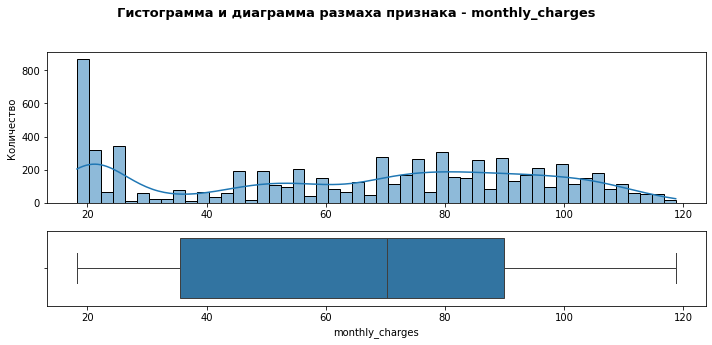

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

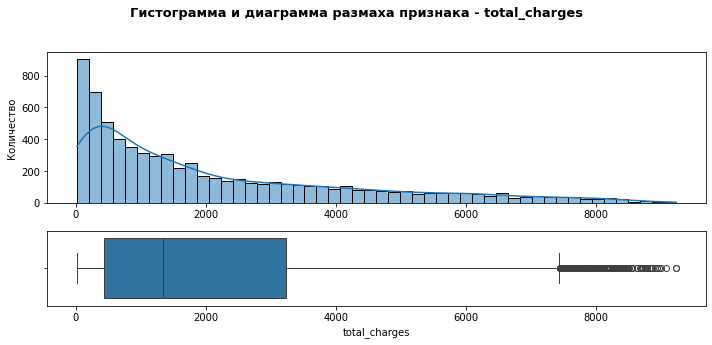

count    7043.000000
mean     2115.377573
std      2112.678861
min        19.050000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: total_charges, dtype: float64

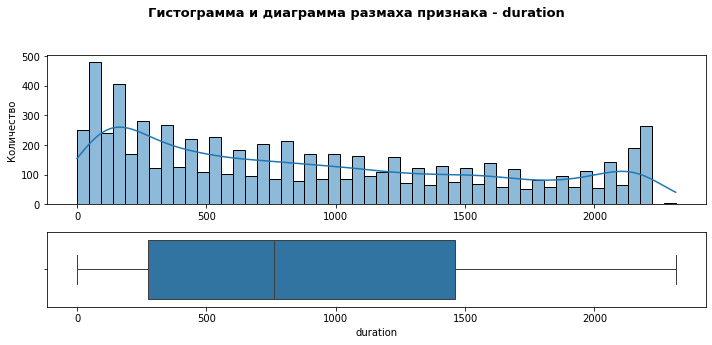

count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: duration, dtype: float64

In [24]:
histbox_plot(df, num_col)

Из диаграмм и таблиц видно, что редкие значения в количественных признаках `total_charges` и `duration` присутствуют, имеются клиенты с большой длительностью договора и высокими общими расходами, при этом аномальные значения не наблюдаются. Признаки  имеют явно ненормальное распределение: смещение вершин к границам диапазона, несколько вершин, учтем это при выборе инструмента для корреляционного анализа данных.

### Cтатистический анализ категориальных признаков

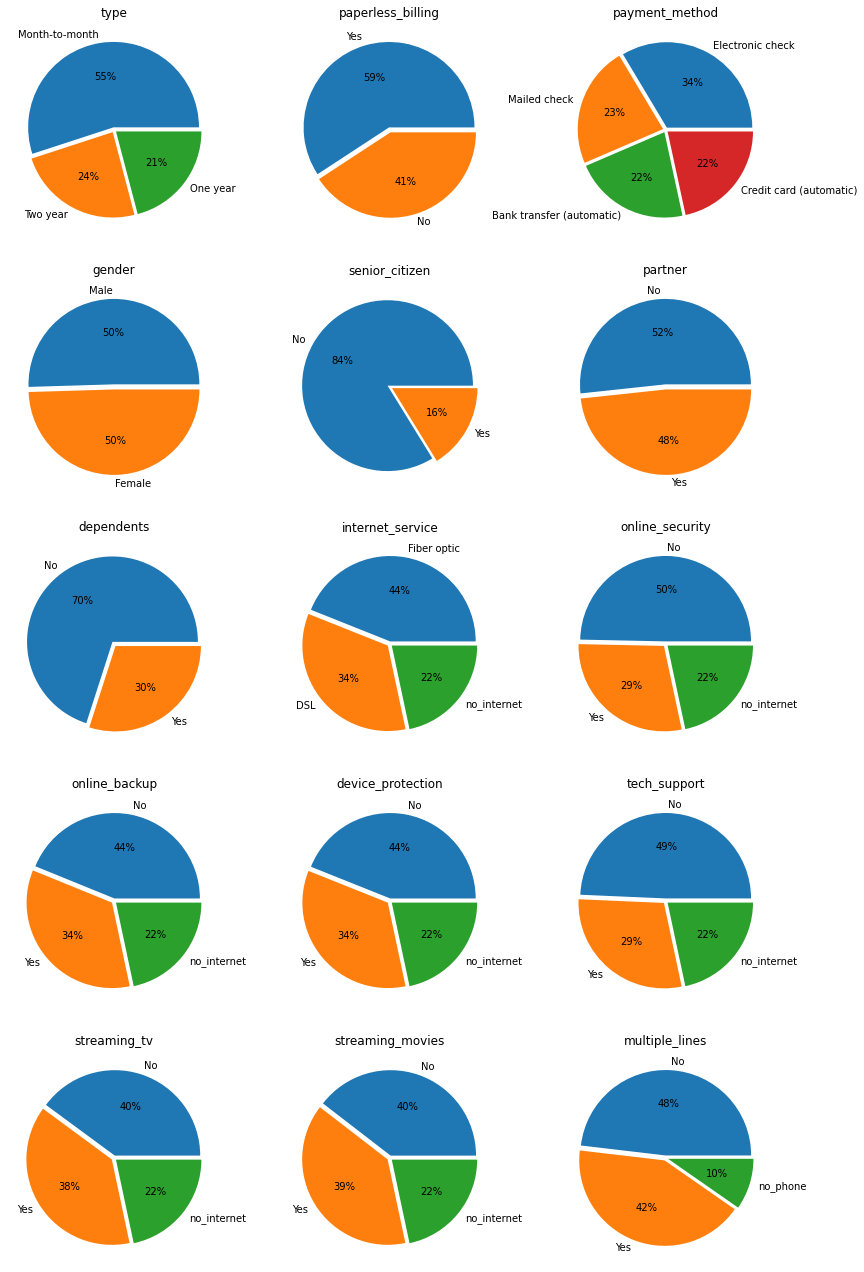

In [25]:
pie_plot(df, cat_col)

Из диаграмм получаем следующую информацию о клиентах:
- женщин/мужчин, имеющих/не имеющих супругу (супруга) примерно поровну
- имеются дети у 30%, пенсионеры составляют 16%
- большинство оплачивает услуги ежемесячно
- большинство предпочитает электронный расчётный лист
- 34% клиентов совершают платеж на основе электронного чека, остальные типы платежей по почте, банковским переводом и кредитной картой, занимают примерно одинаковый объем платежей (22-23%)
- бОльшая часть клиентов использует оптоволоконный кабель для подключения интернета
- большинство пользователей не пользуются услугами: блокировка опасных сайтов, облачное хранилище файлов, антивирус, выделенная линия технической поддержки
- стриминговым телевидением и каталогом фильмов пользуется примерно половина клиентов
- немногим менее половины испоользует подключение телефона к нескольким линиям одновременно
- из представленной выборки 22% клиентов не пользуется услугами интернета, а 10% не пользуется услугами телефонии

### Корреляционный анализ данных

В связи с тем, что данные смешанные и признаки не имеют нормального распределения, для корреляционного анализа используем матрицу Phik, которая устойчива к ненормальному распределению, позволяет учитывать нелинейные зависимости и работает с различными типами признаков

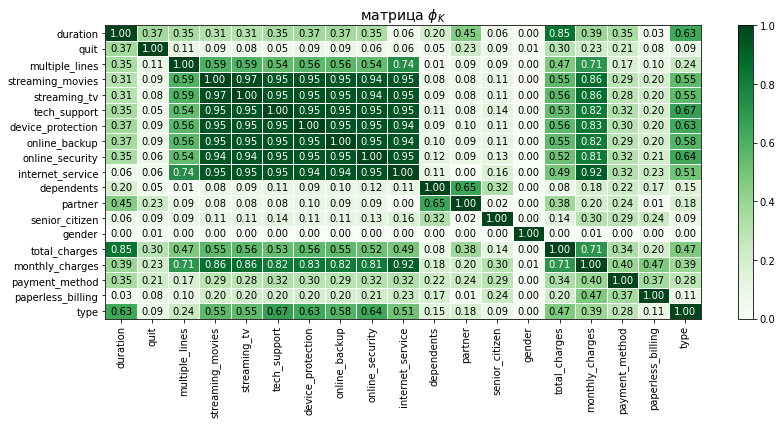

In [26]:
phik_matrix_(df, num_col)

Из матрицы корреляции видно, что мультиколлинеарность наблюдается между всеми признаками датасета с информацией об интернет-услугах. Исключим все указанные признаки, кроме одного `internet_service`. У признака `gender` отсутствует корреляция со всеми признаками, также исключим его  для дальнейшего обучения моделей. Признаки `monthly_charges` и `total_charges` рассчитываются один через другого. С учетом того, что динамики изменения ежемесячных расходов в датасете не представлено и имеется лишь общий срок действия договора, а также, что теснота связи целевого признака выше с `total_charges`, из данных двух признаков оставим для дальнейшего обучения модели только признак `total_charges`.

In [27]:
df = df.drop(['online_security', 'online_backup', 'device_protection',
         'tech_support', 'streaming_tv', 'streaming_movies', 'gender', 'monthly_charges'], axis=1)

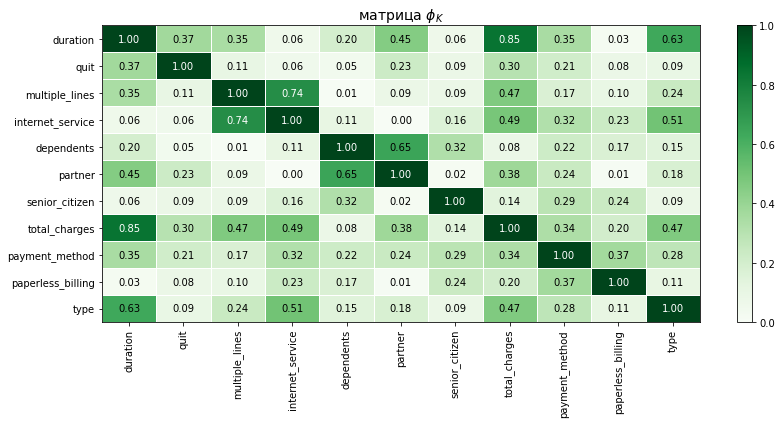

In [28]:
phik_matrix_(df, num_col)

**Вывод:** из анализа матрицы видно, что мультиколлинеарность в данных отсутствует,    
при этом у целевого признака `quit` имеется:
- умеренная теснота связи с признаками `duration` и `total_charges`, с остальными признаками наблюдается слабая связь или ее отсутствие.

По другим признакам наблюдается:
- высокая теснота связи между признаками `total_charges` и `duration`, т.е чем дольше пользователь оставался клиентом компании, тем больше его общие расходы, между признаками `multiple_lines` и `internet_service`, что видимо характеризует продвинутых пользователей в части телефонии и интернета
- заметная теснота связи между признаком `type` и признаками `duration`, `internet_service`. Признаками `partner` и `dependents`, что весьма логично.

По остальным признакам наблюдается по большей части слабая связь или ее отсутствие

### Проверка на дисбаланс классов

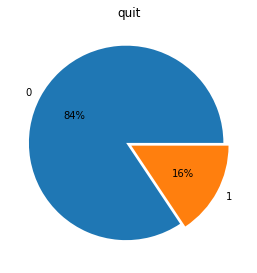

In [29]:
pie_plot(df, ['quit'])

Из диаграммы видно, что дисбаланс классов присутствует, 16% от общего количества клиентов ушли из компании против 84% клиентов, которые имеют действующие договора. В связи с дисбалансом, в качестве метрики выберем `ROC-AUC` - всеохватывающую метрику качества классификации, которая не чувствительна к дисбалансу классов и учитывает работу модели при всех возможных значениях порогов и поэтому не зависит от одного конкретного.

## Подготовка данных

### Обработка неявных дубликатов

В связи с тем, что на  этапе исследовательского анализа был удален ряд признаков, проверим наличие неявных дубликатов в объединенном датасете, т.е без учета признака `customer_id`

In [30]:
print('Количество дубликатов в датасете:', df.duplicated().sum())

Количество дубликатов в датасете: 16


Имеем 16 дубликатов, которые не несут новой информации, т.е. излишне заполняют собой пространство данных, соответственно избыточно перегружают модель и возможно могут навредить обучению модели. Удалим дубликаты

In [31]:
df = df.drop_duplicates()
df.shape

(7027, 11)

### Формирование тренировочной и тестовой выборки

Разобъем данные на тренировочную и тестовую выборки в соотношении 75/25

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['quit'], axis=1),
    df['quit'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df['quit'])

print(X_train.shape, X_test.shape)

(5270, 10) (1757, 10)


In [33]:
num_col = [col for col in df.select_dtypes(include='number').columns if col != 'quit']
num_col

['total_charges', 'duration']

In [34]:
cat_col = df.select_dtypes(exclude='number').columns.tolist()
cat_col

['type',
 'paperless_billing',
 'payment_method',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'multiple_lines']

## Обучение моделей

Для подбора модели будем использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров `GridSearchCV`. Выбор лучшей модели будет осуществляться на основе метрики — `ROC-AUC`

В рамках пайплайна использовались следующие инструменты:    

для кодирования категориальных признаков:
- OneHotEncoder 

для масштабирования количественных признаков:
- StandardScaler, MinMaxScaler, без масштабирования

типы методов:
- LogisticRegression, KNeighborsClassifier, SVC, RandomForestClassifier, LGBMClassifier,  CatBoostClassifier со своими настройками гиперпараметров

Для удобства и сокращения времени проверки на ревью, путем проведения серии обучения моделей с подбором гиперпараметров, был определен диапазон их оптимальных значений, который отражен в приведенном ниже пайплайне.

In [35]:
# создаём списки с названиями признаков
ohe_columns = cat_col
num_columns = num_col

# создаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', None)
])

param_grid = [
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__C': [10, 15, 20],
        'models__solver': ['saga', 'lbfgs', 'liblinear'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
       
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors':[40, 50, 60],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    #словарь для модели SVC()
    {
        'models': [SVC(probability=True, class_weight='balanced', random_state=RANDOM_STATE)],
        'models__kernel': ['rbf','sigmoid'],
        'models__degree':[1],
        'models__C': [1],
        'models__gamma': [0.1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },

    #словарь для модели RandomForestClassifier()
    {
        'models': [RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)],
        'models__max_depth': [5, 10],
        'models__min_samples_leaf': [7, 10],
        'models__min_samples_split': [3],
        'models__max_features': [5, 12],
        'models__n_estimators': [50]
    },

     # словарь для модели LGBMClassifier
    {
        'models': [LGBMClassifier(verbose=-1, random_state=RANDOM_STATE, n_jobs=1)],
        'models__num_leaves': [3, 5],  
        'models__learning_rate': [0.1, 0.125],  
        'models__n_estimators': [1500],  
        'models__max_depth': [2, 3],  
        'models__feature_fraction': [0.5]  
    },
    
    # словарь для CatBoostClassifier
    {
        'models': [CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)],
        'models__depth': [2, 5],  
        'models__learning_rate': [0.1, 0.2],  
        'models__iterations': [1000]  
    }
]

In [36]:
%%time
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

display('Лучшая модель и её параметры:', grid_search.best_params_)
print (f'Метрика ROC-AUC, полученная с помощью кросс-валидации: {grid_search.best_score_:.3f}')

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGB

'Лучшая модель и её параметры:'

{'models': <catboost.core.CatBoostClassifier at 0x7f856643de50>,
 'models__depth': 2,
 'models__iterations': 1000,
 'models__learning_rate': 0.2}

Метрика ROC-AUC, полученная с помощью кросс-валидации: 0.928
CPU times: user 2min 27s, sys: 28.9 s, total: 2min 56s
Wall time: 3min 12s


## Выбор лучшей модели

Отобразим лучшие результаты работы по каждой из моделей

In [37]:
results = pd.DataFrame(grid_search.cv_results_)
results['model_name'] = results['param_models'].apply(lambda x: type(x).__name__)

best_scores = results.groupby('model_name')['mean_test_score'].max().sort_values(ascending=False)

print("Лучшие метрики ROC-AUC для каждой модели:",'\n')
print(best_scores)

Лучшие метрики ROC-AUC для каждой модели: 

model_name
CatBoostClassifier        0.928349
LGBMClassifier            0.912434
SVC                       0.828213
RandomForestClassifier    0.819707
KNeighborsClassifier      0.799978
LogisticRegression        0.751194
Name: mean_test_score, dtype: float64


Моделью, показавшей наилучшие результаты метрики `RMSE` на кроссвалидационной выборке, стала `CatBoostClassifier ` с параметрами: максимальная глубина дерева решений - 2, что является хорошим показателем, т.к модель не является слишком сложной и имеет меньше шансов переобучиться, скорость обучения - 0.2 и количество итераций обучения - 1000.

### График важности признаков для модели

In [38]:
# извлечение лучшего пайплайна и модели
pipeline_best_task2 = grid_search.best_estimator_
model_best_task2 = pipeline_best_task2.named_steps['models']

# извлечем преобразованные названия столбцов и преобразуем X_train, X_test
feature_names = pipeline_best_task2.named_steps['preprocessor'].get_feature_names_out()

X_train_transformed = pipeline_best_task2.named_steps['preprocessor'].transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names)
display(X_train_transformed.shape)

X_test_transformed = pipeline_best_task2.named_steps['preprocessor'].transform(X_test)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)
X_test_transformed.shape

(5270, 15)

(1757, 15)

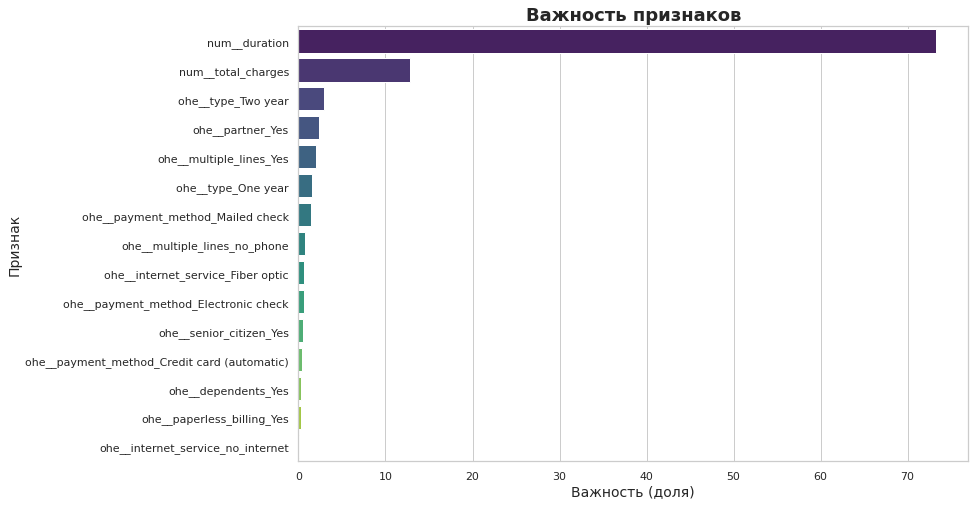

In [39]:
# Формируем таблицу важности признаков и сортируем её
feature_importances = pd.DataFrame(
    {
        'Feature': X_train_transformed.columns,
        'Importance': model_best_task2.feature_importances_
    }).sort_values('Importance', ascending=False)

# Создаем график
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

ax = sns.barplot(data=feature_importances, x='Importance', y='Feature', palette="viridis")

ax.set_title('Важность признаков', fontsize=18, weight='bold')
ax.set_xlabel('Важность (доля)', fontsize=14)
ax.set_ylabel('Признак', fontsize=14);

Анализ важности признаков показывает, что наибольший вклад в предсказание ухода клиента вносят:
- срок действия договора
- общие расходы
- тип оплаты: раз в два года
- наличие супруги или супруга
- наличие подключения телефона к нескольким линиям одновременно

При этом первые два признака имеют в соответствии со своими долями определяющее значение (важность)

### Оценка важности признаков на основе `SHAP`

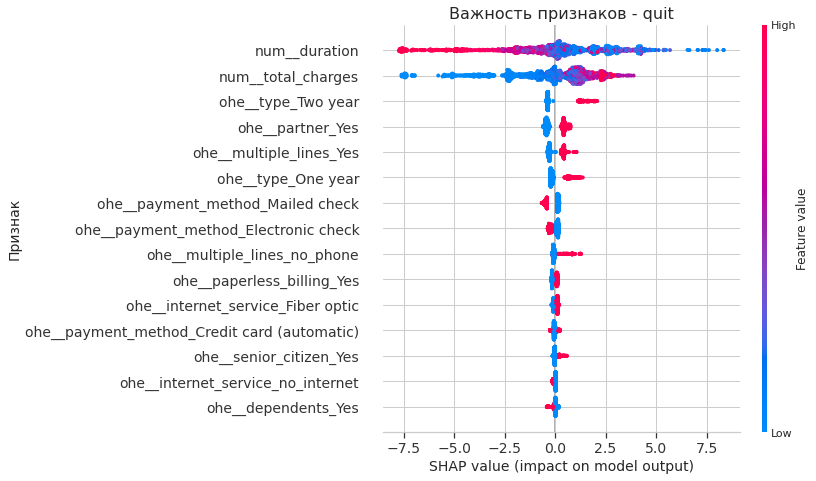

In [40]:
# Рассчитаем SHAP значения для модели CatBoostClassifier
explainer = shap.TreeExplainer(model_best_task2)
shap_values = explainer.shap_values(X_test_transformed)

shap_values_class = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=X_test_transformed)

shap.plots.beeswarm(shap_values_class, max_display=20, show=False)

# Настройка осей и заголовков
fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP value (impact on model output)", fontsize=14)
ax.set_ylabel("Признак", fontsize=14)
ax.set_title('Важность признаков - quit', fontsize=16);

**Вывод:** на основе представленных графиков можно сделать следующие выводы о значимости признаков для прогнозирования:
1. признаки, мало значимые для модели:
- наличие детей
- клиенты, использующие только телефонию
- является ли клиент пенсионером

2. признаки, сильнее всего влияющие на целевой признак и приводящие к повышению вероятности ухода клиента:
- снижение срока действия договора
- увеличение общих расходов клиента
- оплата договора раз в два года
- наличие супруги или супруга
- наличие подключения телефона к нескольким линиям одновременно

При этом первые два признака имеют определяющее значение (важность)

### Матрица ошибок

Проведем анализ лучшей модели на основе матрицы ошибок и ROC-кривой модели

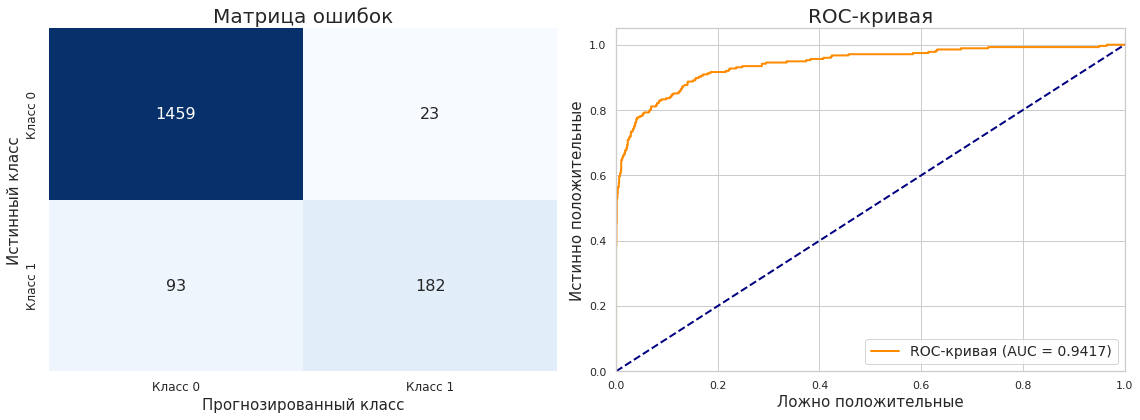

In [41]:
# Предсказания меток и вероятностей
y_pred = grid_search.predict(X_test)
y_probа = grid_search.predict_proba(X_test)[:, 1]

# Построение матрицы ошибок
cm = confusion_matrix(y_test, y_pred)

# Построение ROC-кривой
fpr, tpr, _ = roc_curve(y_test, y_probа)
roc_auc = auc(fpr, tpr)

# Отображение объектов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Матрица ошибок
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16}, ax=ax1)
ax1.set_title('Матрица ошибок', fontsize=20)
ax1.set_xlabel('Прогнозированный класс', fontsize=15)
ax1.set_ylabel('Истинный класс', fontsize=15)
ax1.set_xticks([0.5, 1.5])
ax1.set_xticklabels(['Класс 0', 'Класс 1'], fontsize=12)
ax1.set_yticks([0.5, 1.5])
ax1.set_yticklabels(['Класс 0', 'Класс 1'], fontsize=12)

# ROC-кривая
ax2.plot(fpr, tpr, color='darkorange', lw=2, label='ROC-кривая (AUC = %0.4f)' % roc_auc)
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Ложно положительные', fontsize=15)
ax2.set_ylabel('Истинно положительные', fontsize=15)
ax2.set_title('ROC-кривая', fontsize=20)
ax2.legend(loc="lower right", fontsize=14)
ax2.grid(True)

plt.tight_layout()
plt.show()

**Вывод:** матрица ошибок показывает, что модель значительно лучше справляется с классификацией объектов класса 0, чем с классификацией объектов класса 1, что объясняется дисбалансом классов, где лишь 16% от общего количества клиентов соответствуют классу 1. Возможными решениями будут дополнительный сбор информации о новых клиентах, которые ушли из компании, балансировка классов.

Расчитаем метрики `ROC-AUC и accuracy` для лучшей модели на тестовых данных

In [42]:
# рассчитаем прогноз и метрику SMAPE на тестовых данных

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_probа):.3f}')
print(f'Метрика accuracy на тестовой выборке: {accuracy_score(y_test, y_pred):.3f}')

Метрика ROC-AUC на тестовой выборке: 0.942
Метрика accuracy на тестовой выборке: 0.934


## Общий вывод

**В рамках проекта была проведена:** предобработка данных, исследовательский анализ данных с необходимой визуализацией, статистический анализ признаков по типам, изучена взаимосвязь между признаками на основе корреляционного анализа. По результатам анализа сформирован новый признак и отобраны признаки для последующего обучения моделей.
С целью прогноза ухода клиента из компании обучены шесть моделей, выбрана метрика и лучшая модель на основе данной метрики.    
Проведена оценка важности признаков для лучшей модели, сделаны необходимые выводы о значимости признаков.  
_____________

**На этапе предобработки данных:** названия столбцов были приведены к "змеиному типу", заполнены пропуски в столбце `total_charges` соответствующими данными по месячным расходам клиента. Изменены типы данных в столбцах  `begin_date`, `total_charges`, `senior_citizen` на *datetime*, *float* и *object* соответственно.

**На этапе исследовательского анализа данных:** сформирован целевой признак, уход клиента, в целях дальнейшего обучения моделей - `quit`. Признаки `begin_date` и `end_date` заменены одним признаком - длительностью действия договора в днях `duration`. Для расчета длительности по действующим договорам принята дата окончания их действия за 1 февраля 2020 года - дату, на которую актуальна информация о договорах. Более глубоко исследованы количественные и категориальные данные с использованием графических инструментов, описаны характеристики данных.     

**На этапе корреляционного анализа признаков:** Для исключения мультиколлинеарности, которая  наблюдалась между всеми признаками датасета с информацией об интернет-услугах, для дальнейшего обучения модели были исключены все указанные признаки, кроме `internet_service`. У признака `gender` отсутствовала корреляция со всеми признаками, который также был исключен. Из взаимосвязанных признаков `monthly_charges` и `total_charges`, с учетом того, что динамика изменения ежемесячных расходов в датасете не представлена и имеется лишь общий срок действия договора, а также, что теснота связи целевого признака выше с `total_charges`, из данных двух признаков был оставлен для дальнейшего обучения модели только признак `total_charges`.    

Анализ матрицы `Phik` показал, у целевого признака `quit` имеется:
- умеренная теснота связи с признаками `duration` и `total_charges`, с остальными признаками наблюдается слабая связь или ее отсутствие.

По другим признакам наблюдается:
- высокая теснота связи между признаками `total_charges` и `duration`, т.е чем дольше пользователь оставался клиентом компании, тем больше его общие расходы, между признаками `multiple_lines` и `internet_service`, что видимо характеризует продвинутых пользователей в части телефонии и интернета
- заметная теснота связи между признаком `type` и признаками `duration`, `internet_service`. Признаками `partner` и `dependents`, что весьма логично.    
По остальным признакам наблюдается по большей части слабая связь или ее отсутствие  

Анализ **дисбаланса классов** целевого признака показал, что 16% от общего количества клиентов ушли из компании против 84% клиентов, которые имеют действующие договора. Данный факт учтен при инициализации моделей, использован `class_weihgt`,  чтобы за ошибку на минорном в классе функция ошибки штрафовалась сильнее. Также в связи с дисбалансом, в качестве метрики выбрана `ROC-AUC` - всеохватывающая метрика качества классификации, которая не чувствительна к дисбалансу классов и учитывает работу модели при всех возможных значениях порогов и поэтому не зависит от одного конкретного.

**На этапе подготовки данных:** в связи с тем, что на  этапе исследовательского анализа был удален ряд признаков, была проведена проверка на наличие неявных дубликатов в объединенном датасете, т.е без учета признака `customer_id`, которые были устранены перед обучением модели.

**На этапе обучения моделей:** с использованием пайплайнов обработаны количественные и категориальные признаки, обучены 6 моделей: `LogisticRegression, KNeighborsClassifier, SVC, RandomForestClassifier, LGBMClassifier,  CatBoostClassifier`. Для каждой из моделей подобраны гиперпараметры. Для выбора лучшей модели использовалась метрика `ROC-AUC`, которая составила `0.928` на кроссвалидационной выборке.    

Моделью, показавшей наилучшие результаты на кроссвалидационной выборке, стала `CatBoostClassifier` с параметрами: максимальная глубина дерева решений - 2, что является хорошим показателем, т.к модель не является слишком сложной и имеет меньше шансов переобучиться, скорость обучения - 0.2 и количество итераций обучения - 1000

**На этапе выбора лучшей модели:** была проведена оценка важности признаков для лучшей модели с использованием:
- важности признаков для модели дерева решений
- важности признаков на основе `SHAP`    

Были сделаны следующие выводы о значимости признаков для прогнозирования::
1. признаки, мало значимые для модели:
- наличие детей
- клиенты, использующие только телефонию
- является ли клиент пенсионером

2. признаки, сильнее всего влияющие на целевой признак и приводящие к повышению вероятности ухода клиента:
- снижение срока действия договора
- увеличение общих расходов клиента
- оплата договора раз в два года
- наличие супруги или супруга
- наличие подключения телефона к нескольким линиям одновременно

При этом первые два признака имеют ключевое значение (важность)

Построены матрица ошибок и ROC-кривая итоговой модели:
- матрица ошибок показала, что модель значительно лучше справляется с классификацией объектов класса 0, чем с классификацией объектов класса 1, что объясняется дисбалансом классов, где лишь 16% от общего количества клиентов соответствуют классу 1. Возможными решениями будут дополнительный сбор информации о новых клиентах, которые ушли из компании, балансировка классов.

**Метрики `ROC-AUC и accuracy`** для лучшей модели на тестовых данных составили `0.942 и 0.934` соответственно.
_________
*На основе проведенной работы по проекту можно сделать следующие рекомендации/предложения для бизнеса в целях снижения вероятности ухода клиента из компании:*
- для новых клиентов, которые только заключили договор, предлагать промокоды и специальные условия, например, на первые 1-3 месяца действия договора, чтобы заинтересовать и удержать их.
- стараться удерживать цены на услуги на конкурентном уровне, отслеживать, например, динамику ежемесячных расходов клиента и для клиентов с высокими расходами, также предлагать специальные условия по обслуживанию или скидкам, в т.ч. при заключении договора на более длительный период.
- держать на контроле клиентов, которые производят оплату редко, раз в 2 года, делать для них адресные рассылки со спецпредложениями с целью поддержания их мотивации оставаться клиентами компании.
- формировать семейным клиентам предложения для специального семейного доступа, скидкам на второго члена семьи и т.д.
- для абонентов с подключением телефона к нескольким линиям одновременно, предлагать спецмальные акции, например, оплата со скидкой нескольких телефонных линий при заключении договора на длительный период.